In [1]:
import pandas as pd
import numpy as np
import os

# Perimeter

In [82]:
data = pd.read_parquet("../data/edited_data/modeling/data")

In [83]:
data = data.drop(
    columns=[
        "numVotes",
        "title", 
        "titleType", 
        "Movie", 
        "titleBasicsFlag",
        "primaryTitle",
        "ReleaseDate",
        "nObs",
        "WorldwideGross"],
    axis=1
)

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277451 entries, tt0000038 to tt9916720
Data columns (total 15 columns):
averageRating_name      199591 non-null float64
numVotes_name           199591 non-null float64
averageRating_genres    277451 non-null float64
numVotes_genres         277451 non-null float64
ProductionBudget        3978 non-null float64
DomesticGross           3978 non-null float64
nLetters                277451 non-null float64
nCapitalLetters         277451 non-null float64
nWords                  277451 non-null float64
actor                   78590 non-null float64
director                53534 non-null float64
other                   55131 non-null float64
producer                26142 non-null float64
averageRating           277451 non-null float64
genres                  271751 non-null object
dtypes: float64(14), object(1)
memory usage: 33.9+ MB


In [85]:
data.head()

,averageRating_name,numVotes_name,averageRating_genres,numVotes_genres,ProductionBudget,DomesticGross,nLetters,nCapitalLetters,nWords,actor,director,other,producer,averageRating,genres
tconst,,,,,,,,,,,,,,,
tt0000038,NaN,NaN,7.170422,54.924635,NaN,NaN,13.0,3.0,3.0,NaN,NaN,NaN,NaN,4.2,"Documentary,Short,Sport"
tt0000417,NaN,NaN,7.170422,54.924635,NaN,NaN,18.0,3.0,5.0,NaN,NaN,NaN,NaN,8.2,"Action,Adventure,Comedy"
tt0001440,NaN,NaN,6.226725,5076.682366,NaN,NaN,13.0,2.0,2.0,NaN,NaN,NaN,NaN,4.8,"Drama,History"
tt0001563,NaN,NaN,7.170422,54.924635,NaN,NaN,24.0,4.0,5.0,NaN,NaN,NaN,NaN,5.8,"Crime,Drama,Short"
tt0001889,NaN,NaN,6.226725,5076.682366,NaN,NaN,12.0,1.0,1.0,NaN,NaN,NaN,NaN,4.0,None


### Exploratory analysis

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277451 entries, tt0000038 to tt9916720
Data columns (total 15 columns):
averageRating_name      199591 non-null float64
numVotes_name           199591 non-null float64
averageRating_genres    277451 non-null float64
numVotes_genres         277451 non-null float64
ProductionBudget        3978 non-null float64
DomesticGross           3978 non-null float64
nLetters                277451 non-null float64
nCapitalLetters         277451 non-null float64
nWords                  277451 non-null float64
actor                   78590 non-null float64
director                53534 non-null float64
other                   55131 non-null float64
producer                26142 non-null float64
averageRating           277451 non-null float64
genres                  271751 non-null object
dtypes: float64(14), object(1)
memory usage: 33.9+ MB


In [88]:
genres = data.genres.str.split(",", expand=True).stack(dropna=True).to_frame("genre")
genres.groupby("genre").size().apply(lambda x: x/data.shape[0]).sort_values(ascending=False).nlargest(15)
genresDummies = pd.get_dummies(genres).sum(level=0)
genresDummies.head()

,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000038,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0
tt0000417,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0001440,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0001563,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
tt0002143,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [89]:
list_genres = ["Drama", "Comedy", "Documentary", "Action", "Romance", "Thriller", "Horror", "Crime", "Adventure"]
data["perimeter_genre_flag"] = data.genres.str.split(",").apply(
    lambda x: len(set(x) & set(list_genres)) > 0 if x is not None else False)

data = data.join(genresDummies, how="left")

In [90]:
data

,averageRating_name,numVotes_name,averageRating_genres,numVotes_genres,ProductionBudget,DomesticGross,nLetters,nCapitalLetters,nWords,actor,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000038,NaN,NaN,7.170422,54.924635,NaN,NaN,13.0,3.0,3.0,NaN,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
tt0000417,NaN,NaN,7.170422,54.924635,NaN,NaN,18.0,3.0,5.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0001440,NaN,NaN,6.226725,5076.682366,NaN,NaN,13.0,2.0,2.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0001563,NaN,NaN,7.170422,54.924635,NaN,NaN,24.0,4.0,5.0,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
tt0001889,NaN,NaN,6.226725,5076.682366,NaN,NaN,12.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9915790,NaN,NaN,6.226725,5076.682366,NaN,NaN,15.0,2.0,2.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt9916160,5.800000,16.000000,6.226725,5076.682366,NaN,NaN,10.0,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt9916192,NaN,NaN,6.486580,352.639968,NaN,NaN,42.0,3.0,10.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
perimeter = data[data["perimeter_genre_flag"]]

#### Target

In [43]:
#g = sns.FacetGrid(perimeter, col="genres_first", col_wrap=2)
#g.map(sns.distplot, "averageRating")

#### correlations

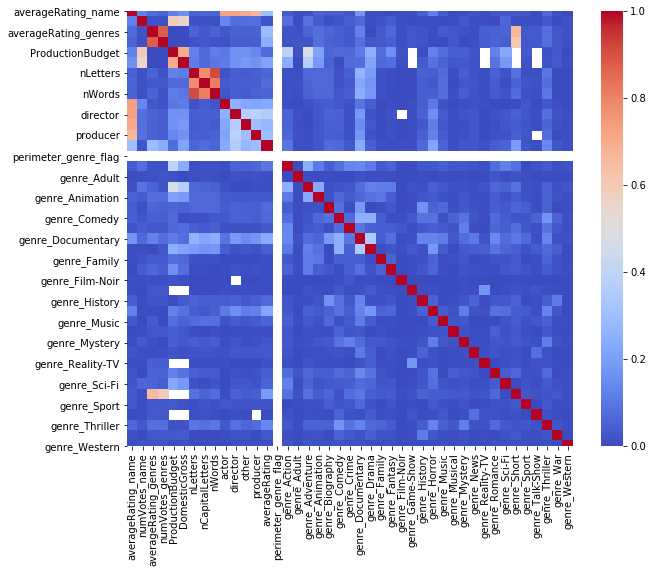

In [92]:
corr = np.abs(perimeter.corr())

fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm")

### Features engineering

#### discretize

In [125]:
perimeter = data[data["perimeter_genre_flag"]]
for category in ["actor", "director", "other", "producer"]:
    cut = pd.cut(perimeter[category], 3, labels=False)
    perimeter[category] = np.where(perimeter[category].isnull(), -1, cut)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [126]:
perimeter.director.value_counts()

-1.0    190443
 1.0     28769
 2.0     19246
 0.0      1991
Name: director, dtype: int64

In [127]:
m = perimeter.averageRating.mean()
sigma = perimeter.averageRating.std()

def get_rate_classes(rate):
    if rate < m - sigma:
        return 0
    if rate < m:
        return 1
    if rate < m + sigma:
        return 2
    else:
        return 3

#perimeter["target"] = (perimeter.averageRating > 8).astype(int)

perimeter["target"] = perimeter.averageRating.apply(get_rate_classes)
#(data.averageRating >= mean_avg_ratings).astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


dropped columns after correlation analysis

In [128]:
cols_drop = [
    "numVotes_name", 
    "averageRating",
    "nLetters", 
    "nCapitalLetters", 
    "averageRating_genres", 
    "numVotes_genres",
    "genres",
    "ProductionBudget",
    "DomesticGross",
    "averageRating_name",
    "genre_Adult",
    "genre_Animation",
    "genre_Biography",
    "genre_Family",
    "genre_Fantasy",
    "genre_Film-Noir",
    "genre_Game-Show",
    "genre_History",
    "genre_Music",
    "genre_Musical",
    "genre_Mystery",
    "genre_News",
    "genre_Reality-TV",
    "genre_Sci-Fi",
    "genre_Short",
    "genre_Sport",
    "genre_Talk-Show",
    "genre_War",
    "genre_Western"
]

In [129]:
perimeter.drop(cols_drop, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Index: 240449 entries, tt0000038 to tt9916720
Data columns (total 16 columns):
nWords                  240449 non-null float64
actor                   240449 non-null float64
director                240449 non-null float64
other                   240449 non-null float64
producer                240449 non-null float64
perimeter_genre_flag    240449 non-null bool
genre_Action            240449 non-null float64
genre_Adventure         240449 non-null float64
genre_Comedy            240449 non-null float64
genre_Crime             240449 non-null float64
genre_Documentary       240449 non-null float64
genre_Drama             240449 non-null float64
genre_Horror            240449 non-null float64
genre_Romance           240449 non-null float64
genre_Thriller          240449 non-null float64
target                  240449 non-null int64
dtypes: bool(1), float64(14), int64(1)
memory usage: 29.6+ MB


### modeling

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [131]:
perimeter = perimeter.drop(columns=cols_drop, axis=1).dropna()

In [132]:
X = perimeter.drop(columns=["target"], axis=1)
y = perimeter.target

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

In [134]:
y_train.value_counts()

2    65534
1    50801
3    26767
0    25212
Name: target, dtype: int64

In [135]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

In [136]:
clf = RandomForestClassifier()
param_grid = {
    'max_depth': [10],
    'n_estimators': [100]
}

grid = GridSearchCV(estimator=clf, param_grid=param_grid, verbose=2)

grid.fit(X_train_scaled, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   4.1s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] ................... max_depth=10, n_estimators=100, total=   4.1s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   3.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [137]:
y_pred = grid.predict(X_test_scaled)

In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.21      0.29     10827
           1       0.40      0.25      0.30     21578
           2       0.43      0.82      0.57     28196
           3       0.25      0.00      0.00     11534

    accuracy                           0.43     72135
   macro avg       0.38      0.32      0.29     72135
weighted avg       0.39      0.43      0.35     72135



In [296]:
contributions = dict(zip(X.columns.tolist(), np.abs((np.std(X_train_scaled, 0) * clf.coef_)[0])))

In [297]:
pd.DataFrame.from_dict(contributions, orient="index").sort_values(by=0, ascending=False)

,0
nWords,0.214649
actor,0.149491
director,0.149491
other,0.149491
producer,0.149491
